In [154]:
import tensorflow as tf
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split
matplotlib_style = 'fivethirtyeight'
import matplotlib.pyplot as plt; plt.style.use(matplotlib_style)

from tools.baysurv_trainer import Trainer
from utility.config import load_config
from utility.training import get_data_loader, scale_data, split_time_event
from tools.baysurv_builder import make_mlp_model, make_vi_model, make_mcd_model, make_sngp_model
from utility.risk import InputFunction
from utility.loss import CoxPHLoss, CoxPHLossLLA
from pathlib import Path
import paths as pt
from utility.survival import (calculate_event_times, calculate_percentiles, convert_to_structured,
                              compute_deterministic_survival_curve, compute_nondeterministic_survival_curve)
from utility.training import make_stratified_split
from time import time
from tools.evaluator import LifelinesEvaluator
from pycox.evaluation import EvalSurv
import math
from utility.survival import coverage
from scipy.stats import chisquare
import torch
from utility.survival import survival_probability_calibration
from tools.Evaluations.util import make_monotonic, check_monotonicity
import matplotlib.colors as colors

In [155]:
dataset_name = "SEER"
model_name = "MLP"

# Load training parameters
config = load_config(pt.MLP_CONFIGS_DIR, f"{dataset_name.lower()}.yaml")
optimizer = tf.keras.optimizers.deserialize(config['optimizer'])
activation_fn = config['activiation_fn']
layers = config['network_layers']
dropout_rate = config['dropout_rate']
batch_size = config['batch_size']
early_stop = config['early_stop']
patience = config['patience']
n_samples_train = config['n_samples_train']
n_samples_valid = config['n_samples_valid']
n_samples_test = config['n_samples_test']

# Load data
dl = get_data_loader(dataset_name).load_data()
num_features = ['Age', 'Tumor Size']
df = dl.get_data()

In [156]:
from tools.preprocessor import Preprocessor

# Split data
df_train, df_valid, df_test = make_stratified_split(df, stratify_colname='both', frac_train=0.7,
                                                    frac_valid=0.1, frac_test=0.2, random_state=0)
X_train = df_train[num_features]
X_valid = df_valid[num_features]
X_test = df_test[num_features]
y_train = convert_to_structured(df_train["time"], df_train["event"])
y_valid = convert_to_structured(df_valid["time"], df_valid["event"])
y_test = convert_to_structured(df_test["time"], df_test["event"])

# Scale data
preprocessor = Preprocessor(cat_feat_strat='mode', num_feat_strat='mean')
transformer = preprocessor.fit(X_train, cat_feats=[], num_feats=num_features,
                               one_hot=True, fill_value=-1)
X_train = transformer.transform(X_train)
X_valid = transformer.transform(X_valid)
X_test = transformer.transform(X_test)

# Convert to array
X_train = np.array(X_train)
X_valid = np.array(X_valid)
X_test = np.array(X_test)

# Make time/event split
t_train, e_train = split_time_event(y_train)
t_valid, e_valid = split_time_event(y_valid)
t_test, e_test = split_time_event(y_test)

# Make event times
event_times = calculate_event_times(t_train, e_train)

# Calculate quantiles
event_times_pct = calculate_percentiles(event_times)

# Make data loaders
train_ds = InputFunction(X_train, t_train, e_train, batch_size=batch_size, drop_last=True, shuffle=True)()
valid_ds = InputFunction(X_valid, t_valid, e_valid, batch_size=batch_size)()
test_ds = InputFunction(X_test, t_test, e_test, batch_size=batch_size)()

# Make MLP model
model = make_mlp_model(input_shape=X_train.shape[1:], output_dim=1,
                       layers=layers, activation_fn=activation_fn,
                       dropout_rate=dropout_rate)
loss_function = CoxPHLoss()

c:\Users\au475271\Miniconda3\envs\py39-baysurv\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [157]:
# Train model
n_epochs = 10
trainer = Trainer(model=model, model_name=model_name,
                  train_dataset=train_ds, valid_dataset=valid_ds,
                  test_dataset=None, optimizer=optimizer,
                  loss_function=loss_function, num_epochs=n_epochs,
                  early_stop=early_stop, patience=patience,
                  n_samples_train=n_samples_train,
                  n_samples_valid=n_samples_valid,
                  n_samples_test=n_samples_test)
trainer.train_and_evaluate()

Completed MLP epoch 1/10
Best Val NLL: inf, epoch Val NNL: 0.47469016909599304
Completed MLP epoch 2/10
Best Val NLL: 0.47469016909599304, epoch Val NNL: 0.4772661030292511
Completed MLP epoch 3/10
Best Val NLL: 0.47469016909599304, epoch Val NNL: 0.48194006085395813
Completed MLP epoch 4/10
Best Val NLL: 0.47469016909599304, epoch Val NNL: 0.48306384682655334
Completed MLP epoch 5/10
Best Val NLL: 0.47469016909599304, epoch Val NNL: 0.48445412516593933
Completed MLP epoch 6/10
Best Val NLL: 0.47469016909599304, epoch Val NNL: 0.48172205686569214
Completed MLP epoch 7/10
Best Val NLL: 0.47469016909599304, epoch Val NNL: 0.4837285578250885
Validation loss converges at 1th epoch.


In [158]:
# Compute survival function
if model_name in ["MLP", "SNGP"]:
    surv_preds = compute_deterministic_survival_curve(model, X_train, X_test,
                                                      e_train, t_train, event_times, model_name)
else:
    surv_preds = np.mean(compute_nondeterministic_survival_curve(model, X_train, X_test,
                                                                 e_train, t_train, event_times,
                                                                 n_samples_train, n_samples_test), axis=0)
# Check monotonicity
if not check_monotonicity(surv_preds):
    surv_preds = make_monotonic(surv_preds, event_times, method='ceil')
    
# Make dataframe
surv_preds = pd.DataFrame(surv_preds, dtype=np.float64, columns=event_times)

In [159]:
plt.rcParams['figure.dpi'] = 140

DEFAULT_X_RANGE = (-2, 1.5)
DEFAULT_Y_RANGE = (-1.5, 6)
DEFAULT_CMAP = colors.ListedColormap(["#377eb8", "#ff7f00"])
DEFAULT_NORM = colors.Normalize(vmin=0, vmax=1,)
DEFAULT_N_GRID = 20

In [167]:
def plot_uncertainty_surface(test_uncertainty, ax, cmap=None):
  """Visualizes the 2D uncertainty surface.

  For simplicity, assume these objects already exist in the memory:

    test_examples: Array of test examples, shape (num_test, 2).
    train_labels: Array of train labels, shape (num_train, ).
    train_examples: Array of train examples, shape (num_train, 2).

  Arguments:
    test_uncertainty: Array of uncertainty scores, shape (num_test,).
    ax: A matplotlib Axes object that specifies a matplotlib figure.
    cmap: A matplotlib colormap object specifying the palette of the
      predictive surface.

  Returns:
    pcm: A matplotlib PathCollection object that contains the palette
      information of the uncertainty plot.
  """
  # Normalize uncertainty for better visualization.
  test_uncertainty = test_uncertainty / np.max(test_uncertainty)

  # Set view limits.
  ax.set_ylim(DEFAULT_Y_RANGE)
  ax.set_xlim(DEFAULT_X_RANGE)

  # Plot normalized uncertainty surface.
  pcm = ax.imshow(
      np.reshape(test_uncertainty, [DEFAULT_N_GRID, DEFAULT_N_GRID]),
      cmap=cmap,
      origin="lower",
      extent=DEFAULT_X_RANGE + DEFAULT_Y_RANGE,
      vmin=DEFAULT_NORM.vmin,
      vmax=DEFAULT_NORM.vmax,
      interpolation='bicubic',
      aspect='auto')

  # Plot training data.
  ax.scatter(X_train[:, 0], X_train[:, 1],
             c=y_train['event'], cmap=DEFAULT_CMAP, alpha=0.5)
  ax.scatter(X_test[:, 0], X_test[:, 1], c="red", alpha=0.1)

  return pcm

In [168]:
def plot_predictions(pred_probs, model_name=""):
  """Plot normalized class probabilities and predictive uncertainties."""
  # Compute predictive uncertainty.
  uncertainty = pred_probs * (1. - pred_probs)

  # Initialize the plot axes.
  fig, axs = plt.subplots(1, 2, figsize=(14, 5))

  # Plots the class probability.
  pcm_0 = plot_uncertainty_surface(pred_probs, ax=axs[0])
  # Plots the predictive uncertainty.
  pcm_1 = plot_uncertainty_surface(uncertainty, ax=axs[1])

  # Adds color bars and titles.
  fig.colorbar(pcm_0, ax=axs[0])
  fig.colorbar(pcm_1, ax=axs[1])

  axs[0].set_title(f"Class Probability, {model_name}")
  axs[1].set_title(f"(Normalized) Predictive Uncertainty, {model_name}")

  plt.show()

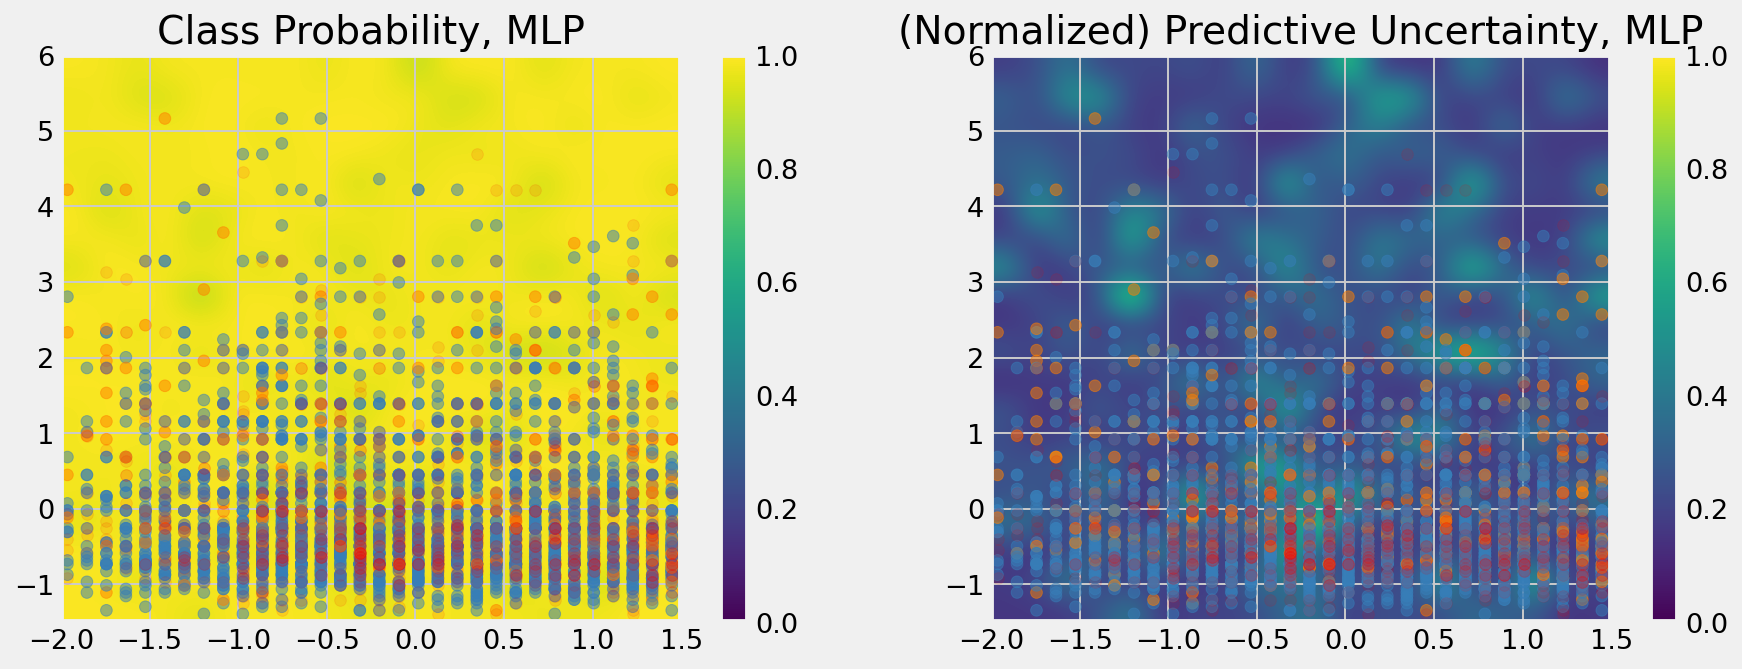

In [183]:
t0 = list(event_times_pct.values())[0]
probs = surv_preds[t0]
#probs = np.clip(1 - surv_preds[t0].squeeze(), 1e-10, 1 - 1e-10)
probs_400 = np.array(probs[np.random.choice(len(probs), size=400, replace=False)])
plot_predictions(probs_400, model_name="MLP")

In [188]:
# Make MLP model
model_name = "MCD"
model = make_mcd_model(input_shape=X_train.shape[1:], output_dim=2,
                       layers=layers, activation_fn=activation_fn,
                       dropout_rate=dropout_rate)
loss_function=CoxPHLossLLA()

n_epochs = 5
trainer = Trainer(model=model, model_name=model_name,
                  train_dataset=train_ds, valid_dataset=valid_ds,
                  test_dataset=None, optimizer=optimizer,
                  loss_function=loss_function, num_epochs=n_epochs,
                  early_stop=early_stop, patience=patience,
                  n_samples_train=n_samples_train,
                  n_samples_valid=n_samples_valid,
                  n_samples_test=n_samples_test)
trainer.train_and_evaluate()

Completed MCD epoch 1/5
Best Val NLL: inf, epoch Val NNL: 0.4117463529109955
Completed MCD epoch 2/5
Best Val NLL: 0.4117463529109955, epoch Val NNL: 0.38998058438301086
Completed MCD epoch 3/5
Best Val NLL: 0.38998058438301086, epoch Val NNL: 0.36140304803848267
Completed MCD epoch 4/5
Best Val NLL: 0.36140304803848267, epoch Val NNL: 0.3572036623954773
Completed MCD epoch 5/5
Best Val NLL: 0.3572036623954773, epoch Val NNL: 0.35089313983917236


In [189]:
surv_preds = np.mean(compute_nondeterministic_survival_curve(model, X_train, X_test,
                                                             e_train, t_train, event_times,
                                                             n_samples_train, n_samples_test), axis=0)
surv_preds = pd.DataFrame(surv_preds, dtype=np.float64, columns=event_times)

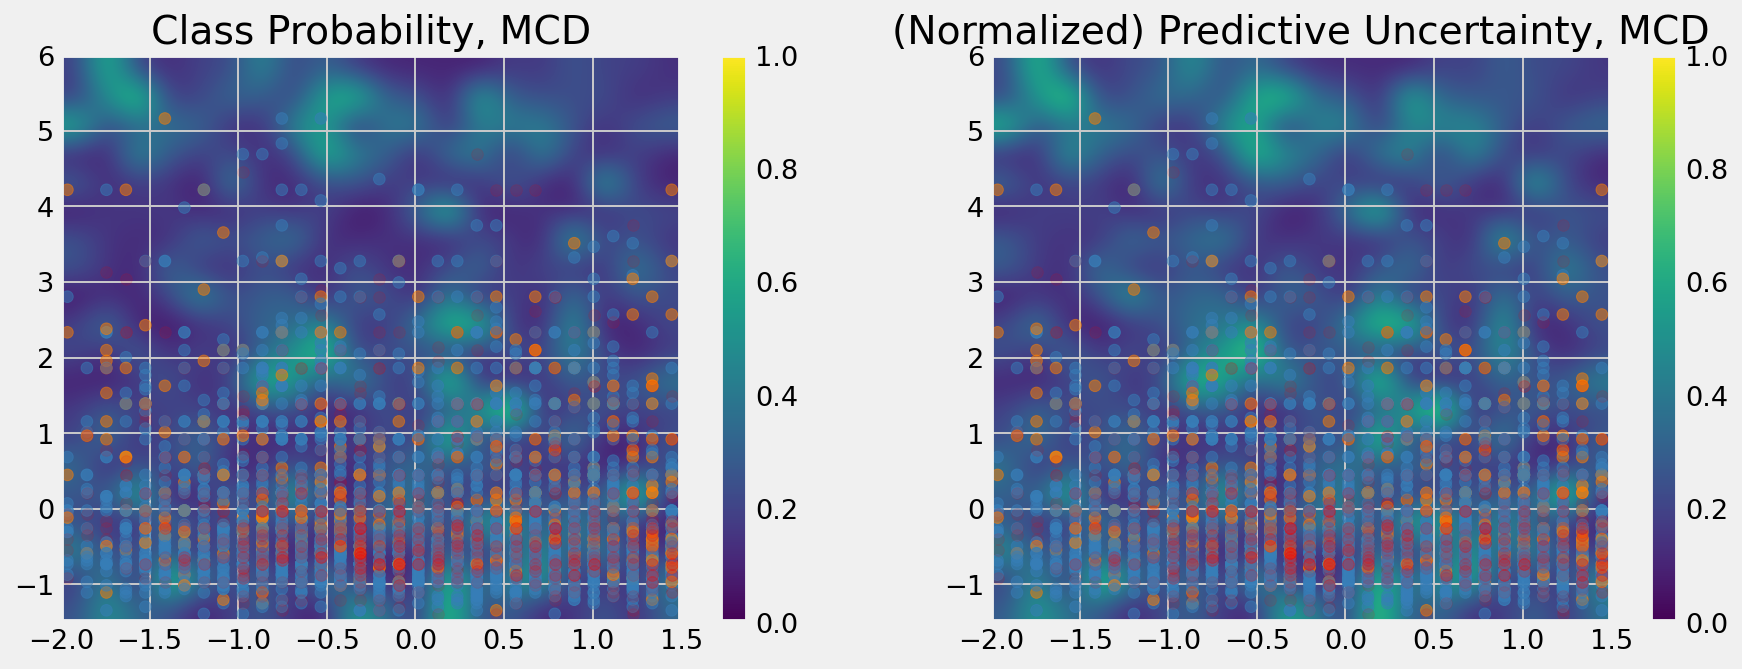

In [191]:
t0 = list(event_times_pct.values())[0]
probs = surv_preds[t0]
probs = np.clip(1 - surv_preds[t0].squeeze(), 1e-10, 1 - 1e-10)
probs_400 = np.array(probs[np.random.choice(len(probs), size=400, replace=False)])
plot_predictions(probs_400, model_name="MCD")